# Tidal analysis
In this notebook we analyse the tidal spectrum of the tracer particles in the NWES and the intertial (MR advection) particles in the NWES to see whether we can measure "the intertia" of the particle from the tides.

In [6]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
from scipy.fft import fft, ifft, fftfreq

from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean, zonal_dist, meridional_dist
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'

basefile_tracer = (base_directory + '{particle_folder}/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_{land_handling}.zarr')

basefile_inertia =  (base_directory + '{particle_folder}/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}.zarr')

particle_types = ['tracer','MR','MRSM']
particle_folders = {'tracer':'tracer','MR':'inertial','MRSM':'inertial_SM'}
basefiles = {'tracer':basefile_tracer, 'MR':basefile_inertia, 'MRSM':basefile_inertia}


dims = {}
dims['MR'] ={'lon':'lon_MR', 'lat':'lat_MR','time':'time_MR'}
dims['tracer'] ={'lon':'lon_tracer', 'lat':'lat_tracer','time':'time_tracer'}
dims['MRSM'] ={'lon':'lon_MRSM', 'lat':'lat_MRSM','time':'time_MRSM'}

In [7]:
# general settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
runtime=timedelta(30)
nparticles = 88347 # 52511
displacement = 100 #m
land_handling = 'anti_beaching'

starttimes = np.array([datetime(2023, 9, 1, 0, 0, 0, 0)]) #,
                    #    datetime(2023, 10, 1, 0, 0, 0, 0),
                    #    datetime(2023, 11, 1, 0, 0, 0, 0),
                    #    datetime(2023, 12, 1, 0, 0, 0, 0) ])#,
                       #datetime(2024, 1, 1, 0, 0, 0, 0),
                       #datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)




In [11]:
chunck_time = 100
years = np.array([2023,2024])
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
data = {}

data[2023] = {}
data[2024] = {}

traj = np.arange(0,nparticles,1)
dslist=[]
for starttime in starttimes:
    print(starttime)
    endtime = starttime + runtime 
    for ptype in particle_types:
        file = basefiles[ptype].format(particle_folder=particle_folders[ptype],
                                       loc=loc,
                                       y_s=starttime.year,
                                       m_s=starttime.month,
                                       d_s=starttime.day,
                                       y_e=endtime.year,
                                       m_e=endtime.month,
                                       d_e=endtime.day,
                                       B = int(B * 1000), 
                                       tau = int(tau ),
                                       land_handling = land_handling)

        ds = xr.open_dataset(file,
                             engine='zarr',
                             chunks={'trajectory':nparticles, 'obs':chunck_time},
                             drop_variables=['B','tau','z','vorticity'],
                             decode_times=False) #,decode_cf=False)

        ds = ds.rename(dims[ptype])
        dslist.append(ds)
    
    data[starttime.year][starttime.month] = xr.merge(dslist)



2023-09-01 00:00:00


Text(0, 0.5, 'latitude [$^{\\circ}$]')

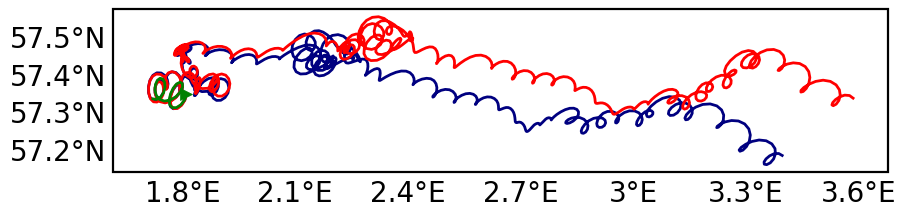

In [10]:
year=2023
month=9


ds = data[year][month]

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()

index= 866 # 1235 8537 20 66
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(ds['lon_tracer'][index,0].values,
        ds['lat_tracer'][index,0].values,
        '>',
        color='green',
        zorder=20)
ax.plot(ds['lon_tracer'][index,0::1].values,
        ds['lat_tracer'][index,0::1].values,
        '-',
        color='navy');

ax.plot(ds['lon_MRSM'][index,0::1].values,
        ds['lat_MRSM'][index,0::1].values,
        '-',
        color='red');

ax.plot(ds['lon_MR'][index,0::1].values,
        ds['lat_MR'][index,0::1].values,
        '-',
        color='green');





gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
# ax.set_xlim(-8,-6)
# ax.set_ylim(55.5,58)

# ax.set_xlim(-8,-6)
# ax.set_ylim(55.5,58)
ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')


In [5]:
ds = data[year][month]
tend = 720
UV_names = {}
UV_names['MR']={'U':'U_MR','V':'V_MR'}
UV_names['MRSM']={'U':'U_MRSM','V':'V_MRSM'}
UV_names['tracer']={'U':'U_tracer','V':'V_tracer'}
delta_t = 2.
for ptype in particle_types:

    U = zonal_dist(lon1 = ds[f'lon_{ptype}'][:,2:].values,
               lon2 = ds[f'lon_{ptype}'][:,0:-2].values,
               lat = ds[f'lat_{ptype}'][:,1:-1].values) / delta_t
    U = np.insert(U,0,np.nan,axis=1)
    U = np.insert(U,799,np.nan,axis=1)
    
    V = meridional_dist(lat1 = ds[f'lat_{ptype}'][:,2:].values,
               lat2 = ds[f'lat_{ptype}'][:,0:-2].values) /delta_t
    V = np.insert(V,0,np.nan,axis=1)
    V = np.insert(V,799,np.nan,axis=1)
    # dtest = data[year][month].assign( test =  U)

    data[year][month] = data[year][month].assign(U=(['trajectory','obs'],U))
    data[year][month] = data[year][month].assign(V=(['trajectory','obs'],V))
    data[year][month]=data[year][month].rename(UV_names[ptype])



# Fourier analysis tides

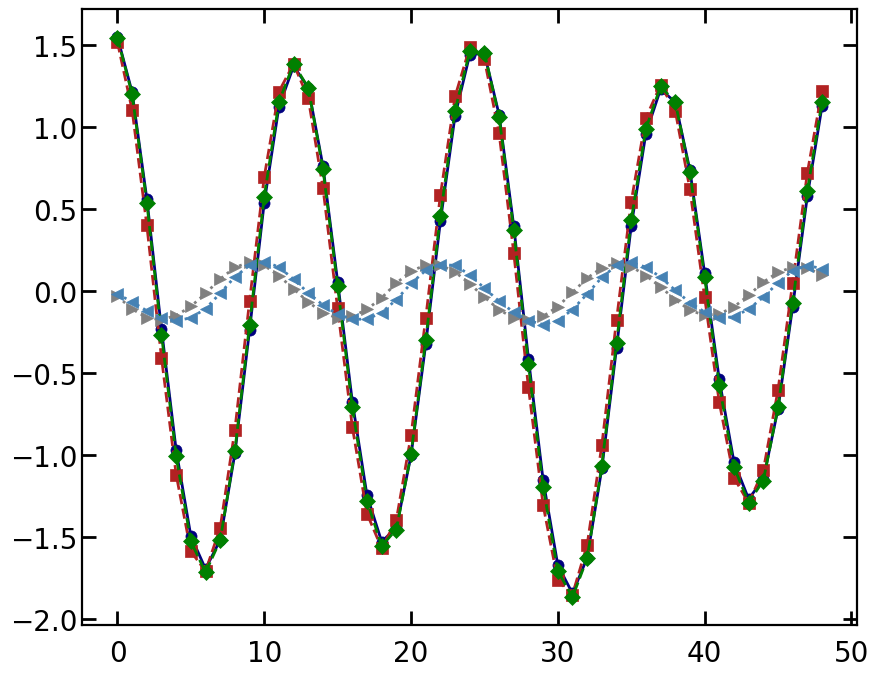

In [6]:
fig, ax = plt.subplots()
tlist = np.arange(0,49,1)
ax.plot( tlist,data[year][month].V_tracer[index,1:50],'-o',color='navy')

ax.plot( tlist,data[year][month].V_MRSM[index,1:50],'--s',color='firebrick')
ax.plot( tlist,data[year][month].V_MR[index,1:50],'--D',color='green')
# ax2= ax.twinx()
ax.plot(tlist, data[year][month].V_MRSM[index,1:50]-data[year][month].V_tracer[index,1:50],':>',color='grey')
ax.plot(tlist, 5*( data[year][month].V_MR[index,1:50]-data[year][month].V_tracer[index,1:50]),':<',color='steelblue')
# ax2.set_ylim(-0.2,0.2)
# ax.set_ylim(-2,2)
#

# Analytical testcase periodic flow
Below we test the tidal analysis for the case where the flow is given by $u_f = A \cos ( \omega_0 t)$ with A = 1 m/s, $\omega_0 = 2 \pi / T_{M2}$ with $T_{M2} = 12.4$ h  
For this flow we can write the analytical expression of the particle velocities using the slow manifold maxey riley equation and the full MR equations. We also use parcels  
to advect particles with this velocity to see whether everything is correct. 


In [7]:
# full MR solution for up with uf = A cos (omega_0 t ) and up(t=0) = uf(t=0) = A 
def up_cos_tracer(t, A,  omega_0):
    """
    Function that describes a homogenous flow periodic (cosine) in time
    with amplitude A and angular frequency omega_0 = 2pi / T with T the period
    """
    return  A *  np.cos(t * omega_0)

def up_cos_MRSM(t, A, omega_0, tau, B):
    """
    Function that returns the full slow manifold MR solution of the   
    particle velocity for a fluid velocity with uf = A cos (omega_0 t)
    """
    return A *  np.cos(t * omega_0) - tau * omega_0 * 2 * (1 - B) / (2 * B + 1) * np.sin(t * omega_0)


def up_cos_MR(t, A, omega_0, tau, B):
    """
    Function that returns the full MR solution of the particle velocity
    for a fluid velocity with uf = A cos (omega_0 t) and up(t=0) = uf(t=0) = A
    """
    dev = A / (tau**2 * omega_0 **2 + 1)
    g_B = 3. / (2 * B +1)
    term1 =  (tau**2 * omega_0**2 * g_B + 1) * np.cos(omega_0 * t) 
    term2 =  tau * omega_0 * (1- g_B) * np.sin(omega_0 * t) 
    term3 = tau**2 * omega_0**2 * (1 - g_B) * np.exp(-t/tau)  
    up = dev * (term1 + term2 + term3) 
    return up

Text(0, 0.5, 'velocity [m/s]')

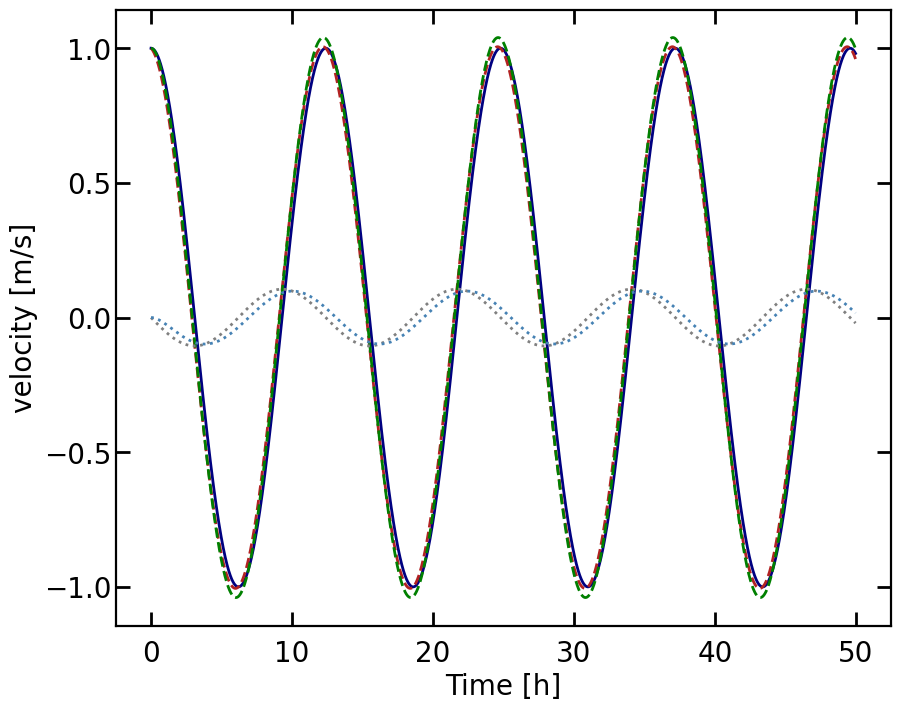

In [8]:
T = 12.4 # h
omega_0 = 2 * np.pi / T
A = 1 # m/s
Ttotal = 50 # h
dt = 0.01 # h
tlist = np.arange(0,Ttotal,dt)

utest_tr = up_cos_tracer(tlist, A, omega_0)
utest_mrsm = up_cos_MRSM(tlist, A, omega_0, tau/3600, B)
utest_mr = up_cos_MR(tlist,A,omega_0, tau/3600 ,B)

fig, ax = plt.subplots()
ax.plot(tlist,utest_tr,'-',color='navy')

ax.plot(tlist,utest_mrsm,'--',color='firebrick')
ax.plot(tlist,utest_mr,'--',color='green')

ax.plot(tlist,utest_mrsm-utest_tr,':',color='grey')
ax.plot(tlist,utest_mr-utest_tr,':',color='steelblue')
ax.set_xlabel('Time [h]')
ax.set_ylabel('velocity [m/s]')


In [9]:
# parcels simulation of particle in this flow
from parcels import FieldSet, AdvectionRK4, ParticleSet, ParticleFile
sys.path.append("../simulations")
from kernels import InertialParticle2D, InitializeParticles2D, deleteParticle, MRAdvectionRK4_2D, MRSMAdvectionRK4_2D,MRAdvectionEC_2D


def cosine_fieldset(Lx, Ly, Tsim, Nt,  Nx, Ny, A, omega_0):
    lon = np.linspace(0, Lx , Nx, dtype=np.float64)
    lat = np.linspace(0, Ly , Ny, dtype=np.float64)
    time = np.linspace(0, Tsim, Nt, dtype=np.float64)
    t, y, x = np.meshgrid(time, lat, lon, indexing='ij')
    U = A * np.cos(omega_0 * t)
    V = 0 * t 
    data = {"U": U,  "V":V }
    dimensions= {"lon":lon, "lat":lat, "time":time}
    fieldset = FieldSet.from_data(data,dimensions,mesh="flat")
    return fieldset
fieldset = cosine_fieldset(Lx = 2000 , Ly = 2000, Tsim = 100, Nt = 201,  Nx = 5, Ny=5, A=1, omega_0 = 2*np.pi /T)

simulations = ['tracer','MR','MRSM']
filenames = {'tracer':'data/tracer_cos_flow.zarr','MR':'data/MR_cos_flow.zarr','MRSM':'data/MRSM_cos_flow.zarr'}
init_kernel = [InitializeParticles2D, deleteParticle]
kernels = {'tracer':[AdvectionRK4, deleteParticle],'MR':[MRAdvectionRK4_2D, deleteParticle],'MRSM':[MRSMAdvectionRK4_2D, deleteParticle]}
dt_timestep=0.5
for simulation in simulations:
    fieldset = cosine_fieldset(Lx = 2000 , Ly = 2000, Tsim = 100, Nt = 201,  Nx = 5, Ny=5, A=1, omega_0 = 2*np.pi /T)
    print('start simulation of ' + simulation)
    fieldset.add_constant('Omega_earth',0)

    # grid spacing
    Delta_x = 1
    Delta_y = 1
    Delta_t = dt_timestep

    # stepsize for finite differences calculation
    delta_x = 0.5 * Delta_x
    delta_y = 0.5 * Delta_y


    fieldset.add_constant('delta_x', delta_x)
    fieldset.add_constant('delta_y', delta_y)
    
    pset = ParticleSet.from_list(fieldset, InertialParticle2D, lon=1000,
                                    lat=1000, time=0,  B=B, tau=tau/3600)
    pset.execute(init_kernel,endtime =1, dt =1)
    pfile = ParticleFile(filenames[simulation], pset, outputdt=0.5)
    pset.execute(kernels[simulation],endtime = 51,dt=0.5, output_file =pfile)


start simulation of tracer
100%|██████████| 1.0/1.0 [00:00<00:00, 682.89it/s]
INFO: Output files are stored in data/tracer_cos_flow.zarr.
100%|██████████| 50.0/50.0 [00:04<00:00, 11.49it/s]
start simulation of MR
100%|██████████| 1.0/1.0 [00:00<00:00, 810.65it/s]
INFO: Output files are stored in data/MR_cos_flow.zarr.
100%|██████████| 50.0/50.0 [00:06<00:00,  7.63it/s]
start simulation of MRSM
100%|██████████| 1.0/1.0 [00:00<00:00, 801.97it/s]
INFO: Output files are stored in data/MRSM_cos_flow.zarr.
100%|██████████| 50.0/50.0 [00:05<00:00,  8.40it/s]


In [265]:
print(tau)

2759.97


In [10]:
dslist=[]
for simulation in simulations:
    ds = xr.open_dataset(filenames[simulation],engine='zarr')
    ds = ds.rename(dims[simulation])
    dslist.append(ds)
data_cos_flow = xr.merge(dslist)

In [263]:
data_cos_flow.lon_MR

<xarray.DataArray 'lon_MR' (trajectory: 3, obs: 100)> Size: 1kB
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
...
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan]],
      dtype=float32)
Coordinates:
  * obs         (obs) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * trajectory  (trajectory) int64 24B 6 7 8
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east

In [11]:

tend = 100
UV_names = {}
UV_names['MR']={'U':'U_MR','V':'V_MR'}
UV_names['MRSM']={'U':'U_MRSM','V':'V_MRSM'}
UV_names['tracer']={'U':'U_tracer','V':'V_tracer'}
delta_t = 2.
for ptype in particle_types:

    U = data_cos_flow[f'lon_{ptype}'][:,2:].values-data_cos_flow[f'lon_{ptype}'][:,0:-2].values
    U = np.insert(U,0,np.nan,axis=1)
    U = np.insert(U,99,np.nan,axis=1)
    V = data_cos_flow[f'lat_{ptype}'][:,2:].values-data_cos_flow[f'lat_{ptype}'][:,0:-2].values
    V = np.insert(V,0,np.nan,axis=1)
    V = np.insert(V,99,np.nan,axis=1)

    # dtest = data[year][month].assign( test =  U)
    data_cos_flow = data_cos_flow.assign(U=(['trajectory','obs'],U))
    data_cos_flow = data_cos_flow.assign(V=(['trajectory','obs'],V))
    data_cos_flow=data_cos_flow.rename(UV_names[ptype])

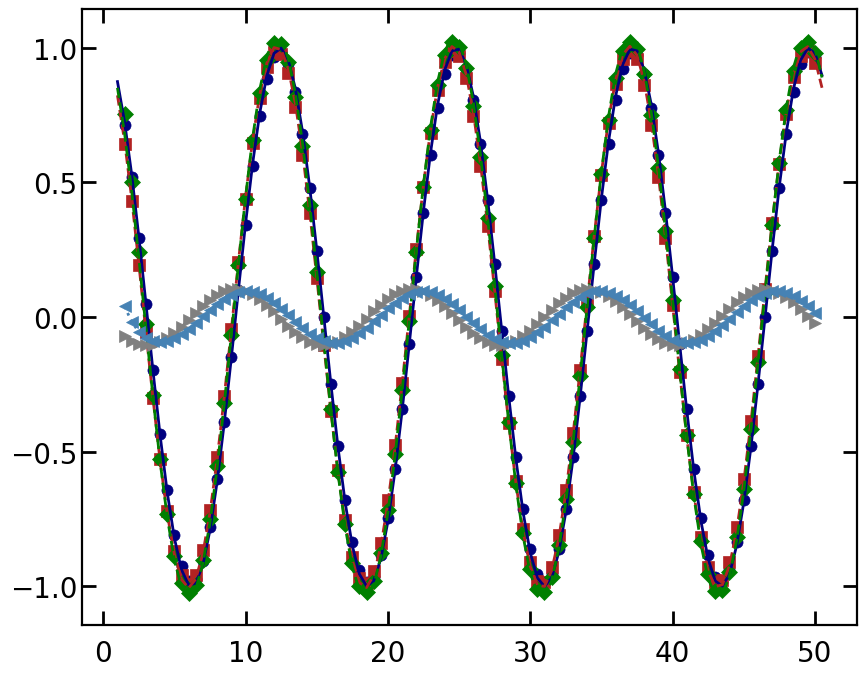

In [ ]:
""" 
notes on 5/12/2024
Analytical expression derived for uf = A cos (omega_0 t) agrees with values simulated using the self written kernels in parcels
before they did not because I made an error in the MRAdvectionRK4_2D, where the time derivative of the first step was accidentely set to zero
This means that I have to redo the simulations (once again..) which I restarted. 
"""


fig, ax = plt.subplots()
tlist = np.arange(1,51,0.5)
index=0
ax.plot( tlist,data_cos_flow.U_tracer[0,:],'o',color='navy')

ax.plot( tlist,data_cos_flow.U_MRSM[2,:],'s',color='firebrick')
ax.plot( tlist,data_cos_flow.U_MR[1,:],'D',color='green')

utest_tr = up_cos_tracer(tlist, A, omega_0)
utest_mrsm = up_cos_MRSM(tlist, A, omega_0, tau/3600, B)
utest_mr = up_cos_MR(tlist,A,omega_0, tau/3600 ,B)


ax.plot(tlist,utest_tr,'-',color='navy')

ax.plot(tlist,utest_mrsm,'--',color='firebrick')
ax.plot(tlist,utest_mr,'--',color='green')
# ax2= ax.twinx()
ax.plot(tlist, data_cos_flow.U_MRSM[2,:]-data_cos_flow.U_tracer[0,:],':>',color='grey')
ax.plot(tlist, ( data_cos_flow.U_MR[1,:]-data_cos_flow.U_tracer[0,:]),':<',color='steelblue')
# ax2.set_ylim(-0.2,0.2)
# ax.set_ylim(-2,2)

In [256]:
data_cos_flow.U_MRSM[index,:]

<xarray.DataArray 'U_MRSM' (obs: 100)> Size: 400B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
  * obs         (obs) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    trajectory  int64 8B 3

In [249]:
data_cos_flow.V_tracer[0,:]

<xarray.DataArray 'V_tracer' (obs: 100)> Size: 400B
array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan], dtype=float32)
Coordinates:
  * obs         (obs) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    trajectory  int64 8B 3

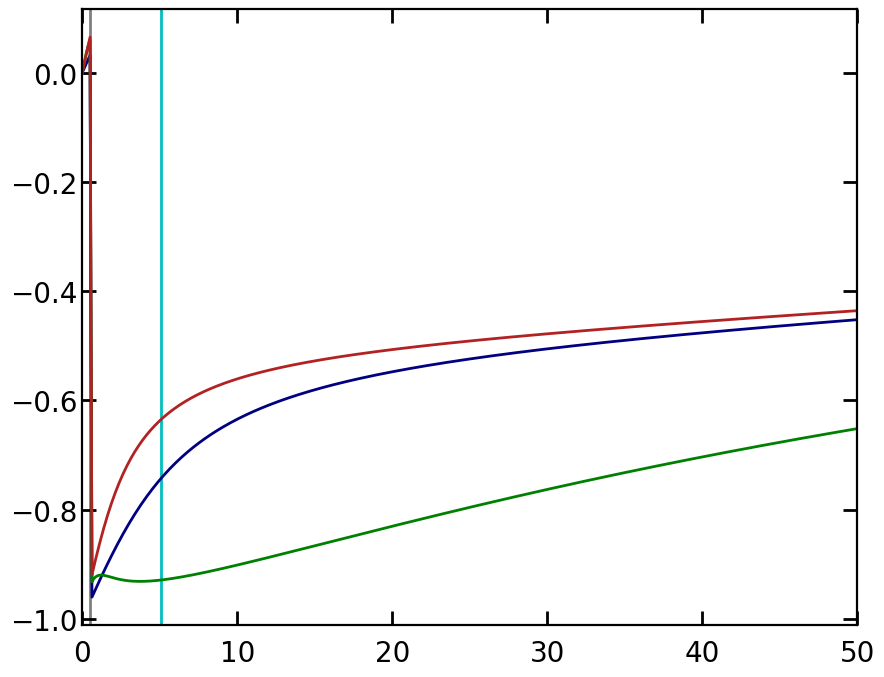

In [178]:
futest_tr = fft(utest_tr)
futest_tr_shift = fft(utest_tr_shift)

futest_mr = fft(utest_mr)
futest_mrsm = fft(utest_mrsm)
dx =0.01
freq=np.arange(0,50,dx)*2*np.pi/50 /dx

fig,ax=plt.subplots()
ax.plot(freq[0:int(futest_tr.size/2)],np.angle(futest_tr)[0:int(futest_tr.size/2)]/np.pi,color='navy')
ax.plot(freq[0:int(futest_tr.size/2)],np.angle(futest_mr)[0:int(futest_tr.size/2)]/np.pi,color='green')
ax.plot(freq[0:int(futest_tr.size/2)],np.angle(futest_mrsm)[0:int(futest_tr.size/2)]/np.pi,color='firebrick')

# ax.plot(freq[0:int(futest_tr.size/2)],(np.angle(futest_mr)-np.angle(futest_tr))[0:int(futest_tr.size/2)]/np.pi,color='green')
# ax.plot(freq[0:int(futest_tr.size/2)],(np.angle(futest_mrsm)-np.angle(futest_tr))[0:int(futest_tr.size/2)]/np.pi,color='firebrick')
# ax.plot(freq[0:int(futest_tr.size/2)],(np.angle(futest_tr_shift)-np.angle(futest_tr))[0:int(futest_tr.size/2)]/np.pi,color='c')
ax.axvline(2 * np.pi /T, color='grey',zorder=-20)
ax.set_xlim(0,50)
ax.axvline(2 * np.pi / (T * 0.1),color='c',zorder=-10)

(0.0, 1.0)

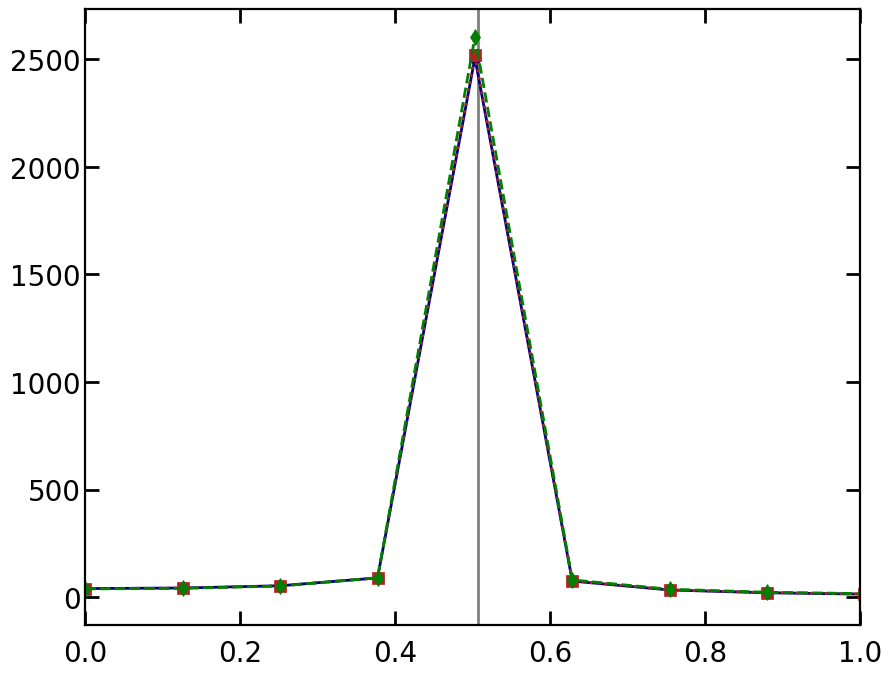

In [132]:
fig,ax=plt.subplots()



ax.plot(freq[0:int(futest_tr.size/2)],np.abs(futest_tr)[0:int(futest_tr.size/2)],'-o',color='navy')
ax.plot(freq[0:int(futest_tr.size/2)],np.abs(futest_mrsm)[0:int(futest_tr.size/2)],':s',color='firebrick')
ax.plot(freq[0:int(futest_tr.size/2)],np.abs(futest_mr)[0:int(futest_tr.size/2)],'--d',color='green')

# ax.set_xscale('log')
ax.axvline(2 * np.pi /T, color='grey',zorder=-20)
ax.set_xlim(0,1)

1.00185
1.006785


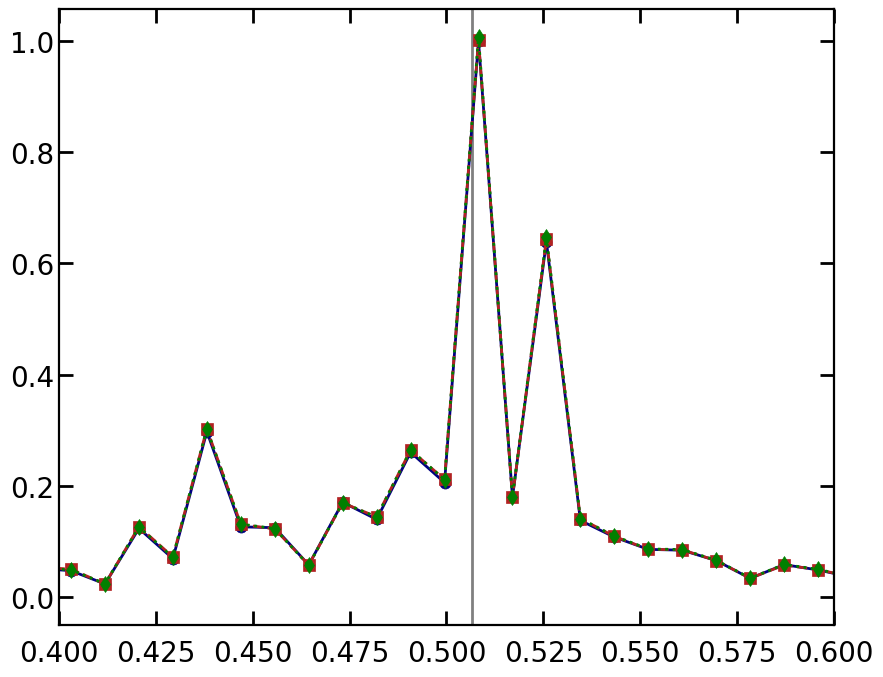

In [188]:
# fourier spectrum
fig, ax = plt.subplots()
Ttotal = 717 #hours
dt = 1 #hour
freq=np.arange(0,Ttotal,dt)*2*np.pi/Ttotal /dt
u_tracer = data[year][month].U_tracer[index,1:718].values
v_tracer = data[year][month].V_tracer[index,1:718].values
vel_tracer = u_tracer + 1j * v_tracer
uf_tracer = fft(u_tracer)
vf_tracer = fft(v_tracer)
velf_tracer = fft(vel_tracer)


# ax.plot(np.abs(uf_tracer),color='navy')
# ax.plot(np.abs(vf_tracer),color='firebrick')
# ax.plot(np.abs(velf_tracer)[0:309],color='grey')

u_MR = data[year][month].U_MR[index,1:718].values
v_MR = data[year][month].V_MR[index,1:718].values
vel_MR = u_MR + 1j * v_MR
uf_MR = fft(u_MR)
vf_MR = fft(v_MR)
velf_MR = fft(vel_MR)

u_MRSM = data[year][month].U_MRSM[index,1:718].values
v_MRSM = data[year][month].V_MRSM[index,1:718].values
vel_MRSM = u_MRSM + 1j * v_MRSM
uf_MRSM = fft(u_MRSM)
vf_MRSM = fft(v_MRSM)
velf_MRSM = fft(vel_MRSM)

# ax.plot( np.abs(uf_MR),'--',color='navy')
# ax.plot(np.abs(vf_MR),'--',color='firebrick')
max = np.max(np.abs(vf_tracer))
ax.plot(freq[0:309],np.abs(vf_tracer)[0:309]/max,'-o',color='navy')
ax.plot(freq[0:309],np.abs(vf_MRSM)[0:309]/max,'--s',color='firebrick')
ax.plot(freq[0:309],np.abs(vf_MR)[0:309]/max,':d',color='green')
ax.axvline(2 * np.pi /T, color='grey',zorder=-20)
ax.set_xlim(0.4,0.6)
print(np.max(np.abs(vf_MRSM)[0:309])/max)
print(np.max(np.abs(vf_MR)[0:309])/max)

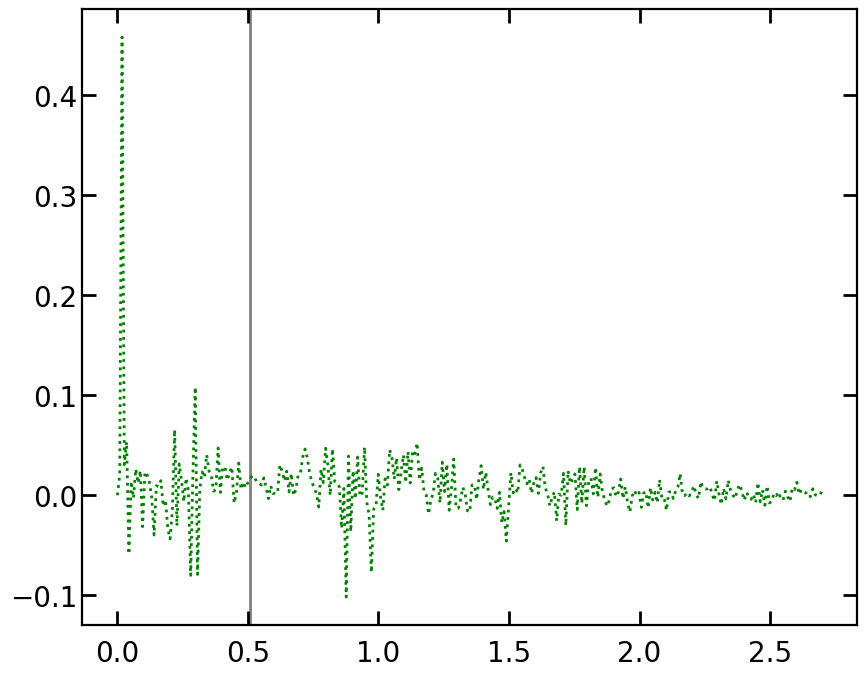

In [123]:
fig, ax = plt.subplots()
# ax.plot(freq[0:309],np.angle(vf_tracer)[0:309],'-',color='navy')
# ax.plot(freq[0:309],(np.angle(vf_MRSM)-np.angle(vf_tracer))[0:309],'--',color='firebrick')
ax.plot(freq[0:309],(np.angle(vf_MR)-np.angle(vf_tracer))[0:309],':',color='green')
ax.axvline(2 * np.pi /12.4, color='grey',zorder=-20)
# ax.set_xlim(0,2)

In [28]:
print(ds.lon_tracer[index,1:tend].values)

[1.8056328 1.7967087 1.7854495 1.7749271 1.7674704 1.7647475 1.767058
 1.7730417 1.7811307 1.7896912 1.7960534 1.7976252 1.7932091 1.7829921
 1.7688553 1.7537799 1.740369  1.730844  1.7264102 1.7266778 1.7305487
 1.7367808 1.7435519 1.7487314 1.7505925 1.7479247 1.7408704 1.7312481
 1.7214007 1.7133996 1.7091061 1.7091669 1.7131426 1.720717  1.7312258
 1.7426977 1.7526004 1.7589998 1.7610362 1.7595934 1.7563722 1.7528982
 1.7510126 1.7520828 1.7563057 1.7632989 1.7724085 1.78219   1.7907597
 1.7967473 1.7992452 1.7984324 1.7958467 1.7931088 1.7915277 1.7924191
 1.7960879 1.8021638 1.8103697 1.8195413 1.827736  1.8335613 1.8362447
 1.8359009 1.8339772 1.8321259 1.8316939 1.8334816 1.8369496 1.8409016
 1.844505  1.8468901 1.8472941 1.8456125 1.8421913 1.8375874 1.8332853
 1.8310827 1.8320296 1.8368415 1.8454667 1.8565401 1.8685683 1.8801057
 1.8892764 1.8945353 1.8950713 1.8908203 1.8834357 1.8759482 1.8706511
 1.8692092 1.8725419 1.8799727 1.890142  1.9016447 1.9124064 1.9201074
 1.9231

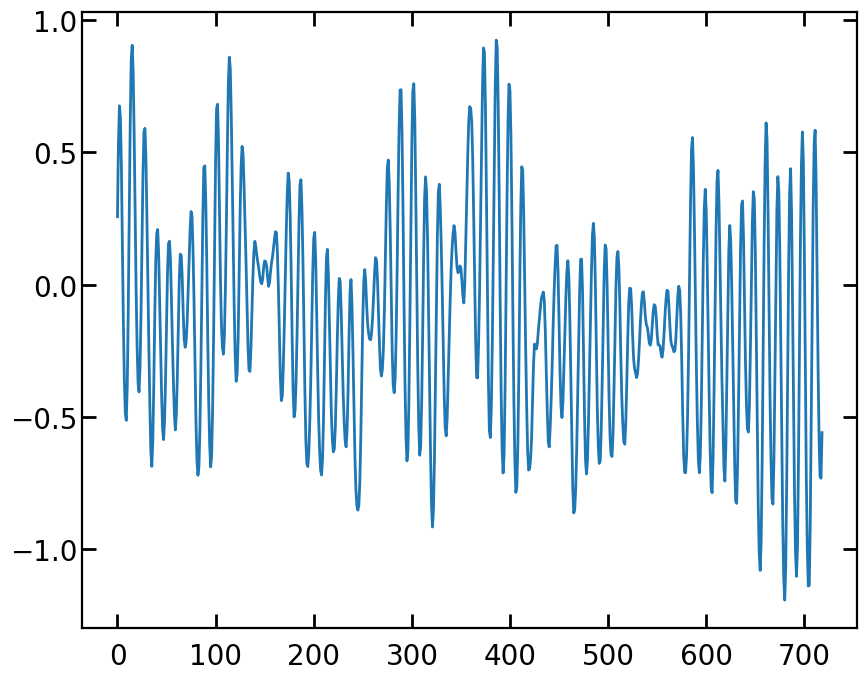

In [43]:
fig,ax=plt.subplots()
ax.plot(U)